<a href="https://colab.research.google.com/github/mobarakol/CIFRA_LT/blob/main/cifar10_lt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR10 Long-tailed:
Original CIFAR10 [0: airplane, 1: automobile, 2: bird, 3: cat, 4: deer, 5: dog, 6: frog, 7: horse, 8: ship, 9: truck] <br>


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import models
import torchvision.transforms as transforms
import os
import argparse
import copy
import random
import numpy as np
device = 'cuda' if torch.cuda.is_available() else 'cpu'
def seed_everything(seed=12):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
parser = argparse.ArgumentParser(description='BalancedLSF Training')
parser.add_argument('--lr', default=0.1, type=float, help='learning rate')
parser.add_argument('--lr_schedule', default=0, type=int, help='lr scheduler')
parser.add_argument('--batch_size', default=1024, type=int, help='batch size')
parser.add_argument('--test_batch_size', default=2048, type=int, help='batch size')
parser.add_argument('--num_epoch', default=50, type=int, help='epoch number')
parser.add_argument('--num_classes', type=int, default=10, help='number classes')
args = parser.parse_args(args=[])

def train(model, trainloader, criterion, optimizer):
    model.train()
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

def test(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    return correct / total

Imbalanced CIFAR class:

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

class IMBALANCECIFAR10(torchvision.datasets.CIFAR10):
    cls_num = 10

    def __init__(self, root, imb_type='exp', imb_factor=0.01, rand_number=0, train=True,
                 transform=None, target_transform=None,
                 download=False):
        super(IMBALANCECIFAR10, self).__init__(root, train, transform, target_transform, download)
        np.random.seed(rand_number)
        img_num_list = self.get_img_num_per_cls(self.cls_num, imb_type, imb_factor)
        self.gen_imbalanced_data(img_num_list)

    def get_img_num_per_cls(self, cls_num, imb_type, imb_factor):
        img_max = len(self.data) / cls_num
        img_num_per_cls = []
        if imb_type == 'exp':
            for cls_idx in range(cls_num):
                num = img_max * (imb_factor**(cls_idx / (cls_num - 1.0)))
                img_num_per_cls.append(int(num))
        elif imb_type == 'step':
            for cls_idx in range(cls_num // 2):
                img_num_per_cls.append(int(img_max))
            for cls_idx in range(cls_num // 2):
                img_num_per_cls.append(int(img_max * imb_factor))
        else:
            img_num_per_cls.extend([int(img_max)] * cls_num)
        return img_num_per_cls

    def gen_imbalanced_data(self, img_num_per_cls):
        new_data = []
        new_targets = []
        targets_np = np.array(self.targets, dtype=np.int64)
        classes = np.unique(targets_np)
        self.num_per_cls_dict = dict()
        for the_class, the_img_num in zip(classes, img_num_per_cls):
            self.num_per_cls_dict[the_class] = the_img_num
            idx = np.where(targets_np == the_class)[0]
            np.random.shuffle(idx)
            selec_idx = idx[:the_img_num]
            new_data.append(self.data[selec_idx, ...])
            new_targets.extend([the_class, ] * the_img_num)
        new_data = np.vstack(new_data)
        self.data = new_data
        self.targets = new_targets
        
    def get_cls_num_list(self):
        cls_num_list = []
        for i in range(self.cls_num):
            cls_num_list.append(self.num_per_cls_dict[i])
        return cls_num_list

class IMBALANCECIFAR100(IMBALANCECIFAR10):
    """`CIFAR100 <https://www.cs.toronto.edu/~kriz/cifar.html>`_ Dataset.
    This is a subclass of the `CIFAR10` Dataset.
    """
    base_folder = 'cifar-100-python'
    url = "https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz"
    filename = "cifar-100-python.tar.gz"
    tgz_md5 = 'eb9058c3a382ffc7106e4002c42a8d85'
    train_list = [
        ['train', '16019d7e3df5f24257cddd939b257f8d'],
    ]

    test_list = [
        ['test', 'f0ef6b0ae62326f3e7ffdfab6717acfc'],
    ]
    meta = {
        'filename': 'meta',
        'key': 'fine_label_names',
        'md5': '7973b15100ade9c7d40fb424638fde48',
    }
    cls_num = 100

Training

In [3]:
seed_everything()
mean_cifar10, std_cifar10 = (0.5071, 0.4866, 0.4409), (0.2009, 0.1984, 0.2023)
transform_train = transforms.Compose([transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(), transforms.ToTensor(),
            transforms.Normalize(mean_cifar10, std_cifar10), ])
transform_test = transforms.Compose([transforms.ToTensor(),
    transforms.Normalize(mean_cifar10, std_cifar10),])
#train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
args.imb_factor = 0.01
train_dataset = IMBALANCECIFAR10(root='./data', imb_type='exp', imb_factor=args.imb_factor, rand_number=0, train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True,num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=2048, shuffle=False, num_workers=4)

model = models.resnet18().to(device)
model.fc = nn.Linear(model.fc.in_features, args.num_classes)
model = model.to(device)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## This cell can be ignored if you wanna use the trained weights from next cell
run epoch

In [7]:

optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=0.9, nesterov=False, weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()

best_epoch, best_acc = 0.0, 0
for epoch in range(args.num_epoch):
    train(model, train_loader, criterion, optimizer)
    accuracy = test(model, test_loader)
    if accuracy > best_acc:
        patience = 0
        best_acc = accuracy
        best_epoch = epoch
        best_model = copy.deepcopy(model)
        torch.save(best_model.state_dict(), 'best_model_cifar10_lt100.pth.tar')
    print('epoch: {}  acc: {:.4f}  best epoch: {}  best acc: {:.4f}'.format(
            epoch, accuracy, best_epoch, best_acc, optimizer.param_groups[0]['lr']))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch: 0  acc: 0.1477  best epoch: 0  best acc: 0.1477
epoch: 1  acc: 0.1499  best epoch: 1  best acc: 0.1499
epoch: 2  acc: 0.1339  best epoch: 1  best acc: 0.1499
epoch: 3  acc: 0.1806  best epoch: 3  best acc: 0.1806
epoch: 4  acc: 0.1735  best epoch: 3  best acc: 0.1806
epoch: 5  acc: 0.2025  best epoch: 5  best acc: 0.2025
epoch: 6  acc: 0.2003  best epoch: 5  best acc: 0.2025
epoch: 7  acc: 0.2193  best epoch: 7  best acc: 0.2193
epoch: 8  acc: 0.2110  best epoch: 7  best acc: 0.2193
epoch: 9  acc: 0.2106  best epoch: 7  best acc: 0.2193
epoch: 10  acc: 0.2368  best epoch: 10  best acc: 0.2368
epoch: 11  acc: 0.2426  best epoch: 11  best acc: 0.2426
epoch: 12  acc: 0.2337  best epoch: 11  best acc: 0.2426
epoch: 13  acc: 0.2456  best epoch: 13  best acc: 0.2456
epoch: 14  acc: 0.2594  best epoch: 14  best acc: 0.2594
epoch: 15  acc: 0.2637  best epoch: 15  best acc: 0.2637
epoch: 16  acc: 0.2683  best epoch: 16  best acc: 0.2683
epoch: 17  acc: 0.2443  best epoch: 16  best acc: 0

Download trained model

In [6]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id = ['1huK_se1kruKhe2GjZABgA97_mCSZuzCK']
downloaded = drive.CreateFile({'id':id[0]}) 
downloaded.GetContentFile('best_model_cifar10_lt100.pth.tar')

## confusion matrix: scratch

In [7]:



def get_confusion_matrix(model, testloader):
    model.eval()
    confusion_matrix = torch.zeros(args.num_classes, args.num_classes)
    correct = 0
    total = 0
    acc_per_class = torch.zeros(args.num_classes)
    samples_per_class = torch.zeros(args.num_classes)
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for t, p in zip(targets.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1
            
            total += targets.size(0)
            correct_matrix = preds.eq(targets)
            correct += correct_matrix.sum().item()
            for cls in range (args.num_classes):
                acc_per_class[cls] += correct_matrix[targets==cls].sum().item()
                samples_per_class[cls] += (targets==cls).sum().item()

    return correct / total, confusion_matrix, acc_per_class/samples_per_class

def get_tp_tn_fp_fn(conf_matrix, nb_classes):
    TP = conf_matrix.diag()
    for c in range(nb_classes):
        idx = torch.ones(nb_classes).byte()
        idx[c] = 0
        # all non-class samples classified as non-class
        TN = conf_matrix[idx.nonzero()[:, None], idx.nonzero()].sum() #conf_matrix[idx[:, None], idx].sum() - conf_matrix[idx, c].sum()
        # all non-class samples classified as class
        FP = conf_matrix[idx, c].sum()
        # all class samples not classified as class
        FN = conf_matrix[c, idx].sum()
        
        print('Class {}\nTP {}, TN {}, FP {}, FN {}, acc={}, recall={}, prec={}, total= {}'.format(
            c, TP[c], TN, FP, FN,(TP[c]+TN)/(TP[c]+TN+FP+FN), TP[c]/(TP[c]+FN), TP[c]/(TP[c]+FP), (TP[c]+TN+FP+FN) ))
    

model.load_state_dict(torch.load('best_model_cifar10_lt100.pth.tar'))
acc, confusion_matrix, acc_per_class = get_confusion_matrix(model, test_loader)
print('confusion matrix:\n', confusion_matrix)
class_wise_acc = confusion_matrix.diag()/confusion_matrix.sum(1)
print('per-class accuracy from CM:', class_wise_acc)
print('per-class accuracy from scratch:', acc_per_class)
print('accuracy-with CM:',class_wise_acc.mean(), ',directly:',acc, ',directly per class to mean:',acc_per_class.mean().item())

get_tp_tn_fp_fn(confusion_matrix, args.num_classes)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


confusion matrix:
 tensor([[907.,  31.,  32.,  19.,   8.,   0.,   3.,   0.,   0.,   0.],
        [ 84., 868.,  14.,  30.,   1.,   1.,   2.,   0.,   0.,   0.],
        [147.,  21., 563., 148.,  95.,  11.,  12.,   3.,   0.,   0.],
        [ 79.,  30., 112., 701.,  56.,  14.,   5.,   3.,   0.,   0.],
        [127.,  16., 186., 205., 440.,   6.,  15.,   5.,   0.,   0.],
        [ 80.,   9., 101., 607.,  71., 118.,   6.,   8.,   0.,   0.],
        [ 43.,  32., 161., 419., 170.,   2., 169.,   4.,   0.,   0.],
        [189.,  31., 102., 326., 181.,  38.,   6., 127.,   0.,   0.],
        [729., 193.,  28.,  40.,   9.,   1.,   0.,   0.,   0.,   0.],
        [260., 627.,  26.,  66.,   9.,   0.,  10.,   2.,   0.,   0.]])
per-class accuracy from CM: tensor([0.9070, 0.8680, 0.5630, 0.7010, 0.4400, 0.1180, 0.1690, 0.1270, 0.0000,
        0.0000])
per-class accuracy from scratch: tensor([0.9070, 0.8680, 0.5630, 0.7010, 0.4400, 0.1180, 0.1690, 0.1270, 0.0000,
        0.0000])
accuracy-with CM: tensor(

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:30.)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:30.)


## confusion matrix: lib

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
#from resources.plotcm import plot_confusion_matrix

def evaluation_all(model, testloader):
    model.eval()
    pred_list = []
    labels_list = []
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            outputs = F.softmax(outputs, dim=1)
            pred_list.append(predicted)
            labels_list.append(targets)

        preds = torch.cat(pred_list).cpu().numpy()
        labels = torch.cat(labels_list).cpu().numpy()
    return correct / total, preds, labels

acc, preds, labels = evaluation_all(model, test_loader)
acc_lib = accuracy_score(labels, preds)
# Confusion matrix
conf_mat=confusion_matrix(labels, preds)
print('confusion matrix:\n',conf_mat)

# Per-class accuracy
class_accuracy=conf_mat.diagonal()/conf_mat.sum(1)
print('per-class accuracy:',class_accuracy)
print('accuracy-with CM:',class_accuracy.mean(), ',directly:',acc, 'lib:',acc_lib)

print(metrics.classification_report(labels, preds, digits=3))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


confusion matrix:
 [[907  31  32  19   8   0   3   0   0   0]
 [ 84 868  14  30   1   1   2   0   0   0]
 [147  21 563 148  95  11  12   3   0   0]
 [ 79  30 112 701  56  14   5   3   0   0]
 [127  16 186 205 440   6  15   5   0   0]
 [ 80   9 101 607  71 118   6   8   0   0]
 [ 43  32 161 419 170   2 169   4   0   0]
 [189  31 102 326 181  38   6 127   0   0]
 [729 193  28  40   9   1   0   0   0   0]
 [260 627  26  66   9   0  10   2   0   0]]
per-class accuracy: [0.907 0.868 0.563 0.701 0.44  0.118 0.169 0.127 0.    0.   ]
accuracy-with CM: 0.3893 ,directly: 0.3893 lib: 0.3893
              precision    recall  f1-score   support

           0      0.343     0.907     0.498      1000
           1      0.467     0.868     0.607      1000
           2      0.425     0.563     0.484      1000
           3      0.274     0.701     0.394      1000
           4      0.423     0.440     0.431      1000
           5      0.618     0.118     0.198      1000
           6      0.741     0.169 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Drawing confusion matrix

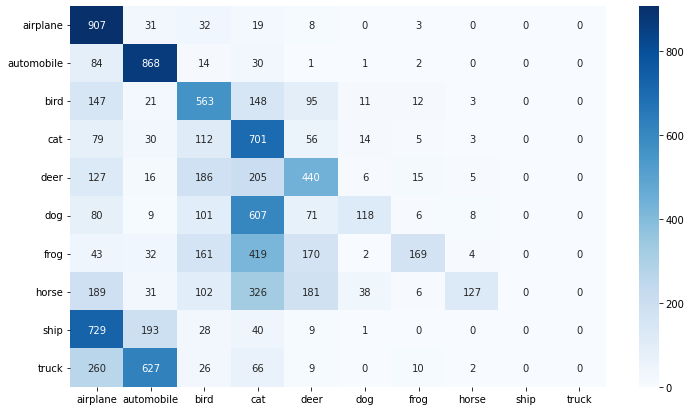

In [12]:
import seaborn as sn
import pandas as pd
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
df_cm = pd.DataFrame(conf_mat, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')